In [1]:
import psrchive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import matplotlib

%matplotlib inline

<open file '/usr/local/lib/python2.7/dist-packages/_psrchive.so', mode 'rb' at 0x7f9be104d420> /usr/local/lib/python2.7/dist-packages/_psrchive.so ('.so', 'rb', 3)


In [2]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})
sns.set_style('white', rc={'axes.linewidth': 0.5})

### Data Prep

See this [post](https://griffinfoster.github.io/BL_dspsr/).

---

### Load Archive Files

In [3]:
def gaussianFilter(arrShape, tSigma, fSigma):
    # Gaussian filter
    # arrShape: 2-D array shape
    # tSigma: sigma in time (ms)
    # fSigma: sigma in freq (MHz)
    lpos, mpos = np.mgrid[0:arrShape[0],0:arrShape[1]]
    taper = np.exp(-1. * ( (((lpos - (arrShape[0]/2.))**2.) / (2. * tSigma**2.)) + \
                           (((mpos - (arrShape[1]/2.))**2.) / (2. * fSigma**2.)) ))
    print (1. / (2. * np.pi * tSigma * fSigma))
    #return (1. / (2. * np.pi * tSigma * fSigma)) * taper
    return taper

def convolveTaper(gaussImg, img):
    return np.fft.fftshift(np.fft.ifft2(np.fft.fft2(gaussImg, norm='ortho') * np.fft.fft2(img, norm='ortho'),\
                                        norm='ortho')).real

In [4]:
tInt = 0.7489828571428683 # seconds, HARDCODE

In [5]:
# load dynamic spectra
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.ar')
upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.calibP')
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.RM') # RM -3160
#upperAr = psrchive.Archive_load('upper_halfband/FRB180301_upper.RM0') # 3160

#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.ar')
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.calibP')
lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.rfi')
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.RM') # RM -3160
#lowerAr = psrchive.Archive_load('lower_halfband/FRB180301_lower.RM0') # RM 3160

In [6]:
# Baseline removal
upperAr.remove_baseline()
lowerAr.remove_baseline()

# Convert data to Stokes
upperAr.convert_state('Stokes')
lowerAr.convert_state('Stokes')

In [7]:
freq_lo = upperAr.get_centre_frequency() - upperAr.get_bandwidth()/2.0
freq_hi = upperAr.get_centre_frequency() + upperAr.get_bandwidth()/2.0
print freq_lo
print freq_hi

freq_lo = lowerAr.get_centre_frequency() - lowerAr.get_bandwidth()/2.0
freq_hi = lowerAr.get_centre_frequency() + lowerAr.get_bandwidth()/2.0
print freq_lo
print freq_hi

deltaNu = upperAr.get_bandwidth() / upperAr.get_nchan()
freqsMHz = np.arange(upperAr.get_nchan() + lowerAr.get_nchan()) * deltaNu + (0.5 * deltaNu) +\
        (upperAr.get_centre_frequency() - upperAr.get_bandwidth()/2.0)
print freqsMHz

1513.75
1359.75
1359.75
1205.75
[ 1513.6953125  1513.5859375  1513.4765625 ...,  1206.0234375  1205.9140625
  1205.8046875]


In [8]:
upperData = upperAr.get_data()
lowerData = lowerAr.get_data()
upperWgts = upperAr.get_weights()
lowerWgts = lowerAr.get_weights()

print upperWgts.shape
for sint in np.arange(upperData.shape[0]):
    for pol in np.arange(upperData.shape[1]):
        upperData[sint,pol] = np.multiply(upperData[sint,pol].T, upperWgts[sint]).T
        lowerData[sint,pol] = np.multiply(lowerData[sint,pol].T, lowerWgts[sint]).T

print upperData.shape
print lowerData.shape

data = np.concatenate((upperData, lowerData), axis=2)
print data.shape

(1, 1408)
(1, 4, 1408, 32768)
(1, 4, 1408, 32768)
(1, 4, 2816, 32768)


In [9]:
# normalization region
phase0 = 0.5
phase1 = 0.8
phase = np.linspace(0, 1, data.shape[3])
phase0Idx = np.argmin(np.abs(phase - phase0))
phase1Idx = np.argmin(np.abs(phase - phase1))
subData = data[:,:,:,phase0Idx:phase1Idx]
normBandpass = np.mean(subData[0], axis=2)

---

### RM Fit Solution

In [10]:
rmSpectrum = np.loadtxt('upper_halfband/rm_spectrum.txt')

-3153.15


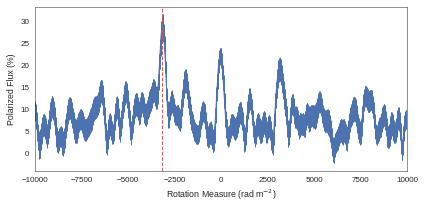

In [11]:
snrMaxRM = rmSpectrum[np.argmax(rmSpectrum[:,1]), 0]
print snrMaxRM

fig = plt.figure(figsize=(6,3)) # (width, height)

plt.errorbar(rmSpectrum[:,0], rmSpectrum[:,1], yerr=rmSpectrum[:,2])

plt.axvline(snrMaxRM, c='indianred', ls='--')

plt.xlim(rmSpectrum[0,0], rmSpectrum[-1,0])

plt.xlabel('Rotation Measure (rad m$^{-2}$)')
#plt.ylabel('Polarized Flux (Jy)')
plt.ylabel('Polarized Flux (%)')

plt.tight_layout()
#plt.savefig('figures/rmfit.pdf')

### Dynamic Spectrum

In [12]:
# select a region in phase
phase0 = 0.575
phase1 = 0.597

phase = np.linspace(0, 1, data.shape[3])
phase0Idx = np.argmin(np.abs(phase - phase0))
phase1Idx = np.argmin(np.abs(phase - phase1))
subData = data[:,:,:,phase0Idx:phase1Idx]

#ts0 = 1000. * tInt * phase0 # ms
#ts1 = 1000. * tInt * phase1 # ms
ts0 = 0. # ms
ts1 = 1000. * tInt * (phase1 - phase0) # ms

In [13]:
# normalize (remove bandpass)
applyNorm = False

if applyNorm:
    normSubData = np.zeros_like(subData)
    for pIdx in range(4):
        #normSubData[0,pIdx] = (subData[0,pIdx].T - np.mean(subData[0,pIdx], axis=1).T).T
        normSubData[0,pIdx] = (subData[0,pIdx].T - normBandpass[pIdx].T).T
else:
    normSubData = subData.copy()

Using Measured SEFD: 37.041212 Jy
16.2746


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide


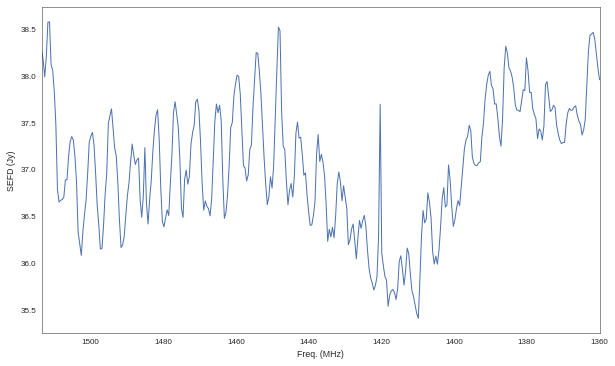

In [14]:
# Flux Calibration
applyHistScaling = False # Historical SEFD scaling
applyScaling = True # Measured SEFD scaling
npol = 2 # 2 for Stokes, 1 for coherency

if applyHistScaling:
    SEFD = 30. # Jy, https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_3.html
    print 'Using Historical SEFD: %f Jy'%SEFD
    
    fluxScaling = SEFD / np.sqrt(npol * np.abs(deltaNu * 1e6) * tInt/data.shape[3])
    #print fluxScaling
    #print np.std(normSubData[0,0], axis=1)
    
    scaleFactor = fluxScaling / np.std(normSubData[0,0], axis=1)
    scaleFactor[scaleFactor == np.inf] = 0.
    scaleSubData = np.zeros_like(normSubData)
    for pIdx in range(4):
        scaleSubData[0,pIdx] = (normSubData[0,pIdx].T * scaleFactor).T
        
elif applyScaling:
    measuredSEFD = np.loadtxt('frb180301_sefd_cal.csv', delimiter=',') # From Danny, see fb180301_SEFD.pdf
    
    fig = plt.figure(figsize=(10,6)) # (width, height)
    plt.plot(measuredSEFD[:,0], measuredSEFD[:,1])
    plt.xlabel('Freq. (MHz)')
    plt.ylabel('SEFD (Jy)')
    plt.xlim(measuredSEFD[0,0], measuredSEFD[-1,0])
    SEFD = measuredSEFD[:,1].mean() # use the mean SEFD
    print 'Using Measured SEFD: %f Jy'%SEFD
    
    fluxScaling = SEFD / np.sqrt(npol * np.abs(deltaNu * 1e6) * tInt/data.shape[3])
    #print fluxScaling
    #print np.std(normSubData[0,0], axis=1)
    scaleFactor = fluxScaling / np.std(normSubData[0,0], axis=1)
    scaleFactor[scaleFactor == np.inf] = 0.
    scaleSubData = np.zeros_like(normSubData)
    for pIdx in range(4):
        scaleSubData[0,pIdx] = (normSubData[0,pIdx].T * scaleFactor).T
        
else:
    scaleSubData = normSubData.copy() # no scaling
    
print np.std(scaleSubData[0,0])

(46,)


/home/griffin/.local/lib/python2.7/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


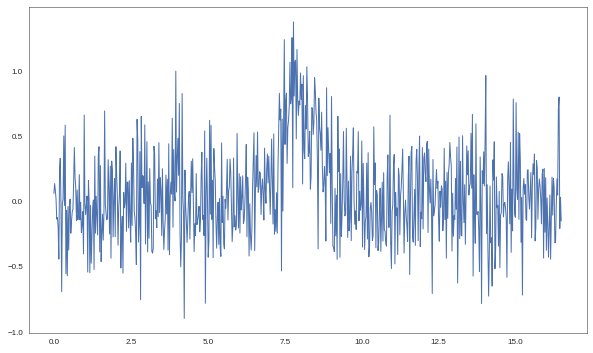

In [15]:
import scipy.signal

fig = plt.figure(figsize=(10,6)) # (width, height)

rawTimeSeries = scaleSubData[0,0].mean(axis=0)

print scipy.signal.decimate(rawTimeSeries, 16).shape

ts = np.linspace(ts0, ts1, scaleSubData.shape[3])
plt.plot(ts, rawTimeSeries)
#plt.plot(scipy.signal.decimate(rawTimeSeries, 8))

(1390, 1431)

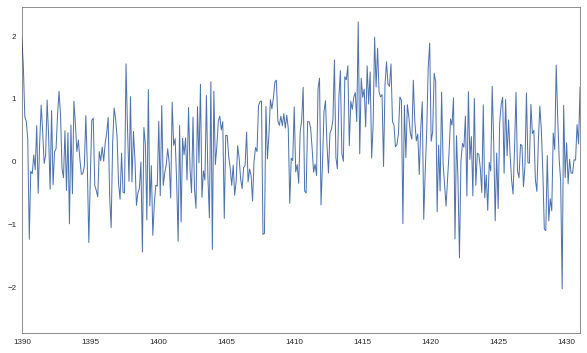

In [16]:
fig = plt.figure(figsize=(10,6)) # (width, height)

rawSpectrums = scaleSubData[0,0].mean(axis=1)

plt.plot(freqsMHz, rawSpectrums)
plt.xlim(1390, 1431)

In [17]:
# Gaussian filter
applyGauss = True

if applyGauss:
    fGauss = 2.
    tGauss = 4.
    gaussSubData = np.zeros_like(normSubData)
    gaussImg = gaussianFilter(scaleSubData[0,0].shape, tGauss, fGauss)
    for pIdx in range(4):
        gaussSubData[0,pIdx] = convolveTaper(gaussImg, normSubData[0,pIdx])
else:
    gaussSubData = scaleSubData.copy()
    
print np.std(gaussSubData[0,0])

0.0198943678865
1.79858


In [18]:
# find peak
print gaussSubData[0,0].shape
peakIdx = np.unravel_index(np.argmax(gaussSubData[0,0]), gaussSubData[0,0].shape)
print peakIdx
tWidth = 12
#tIdx0 = peakIdx[1] - tWidth
#tIdx1 = peakIdx[1] + tWidth

#tIdx0 = 330
#tIdx1 = 370

tIdx0 = 325
tIdx1 = 375

(2816, 721)
(900, 339)


1513.6953125 1205.8046875
1.23039


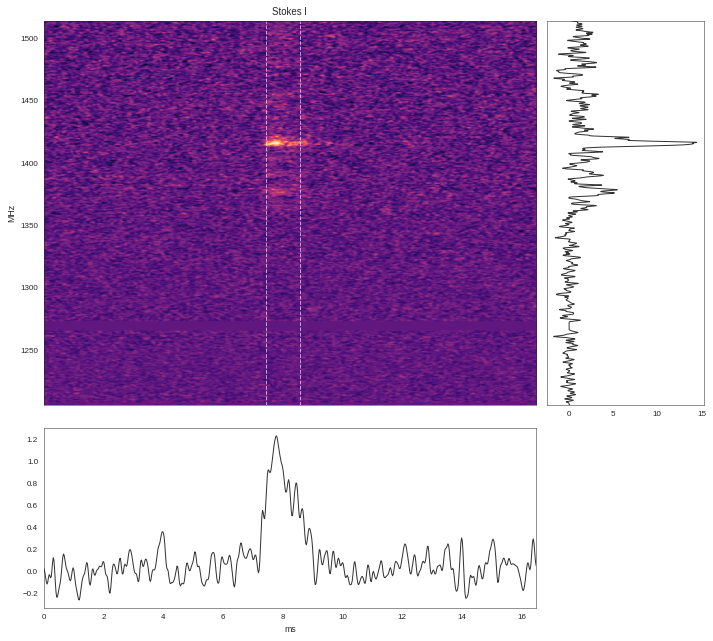

In [19]:
# Stokes I
polStr = 'Stokes I'
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

print freqsMHz[0], freqsMHz[-1]

ax3.get_yaxis().set_visible(False)

plt.tight_layout()
#plt.savefig('180301_stokesI_dedsip.png')

print np.max(timeSeries[0,0])

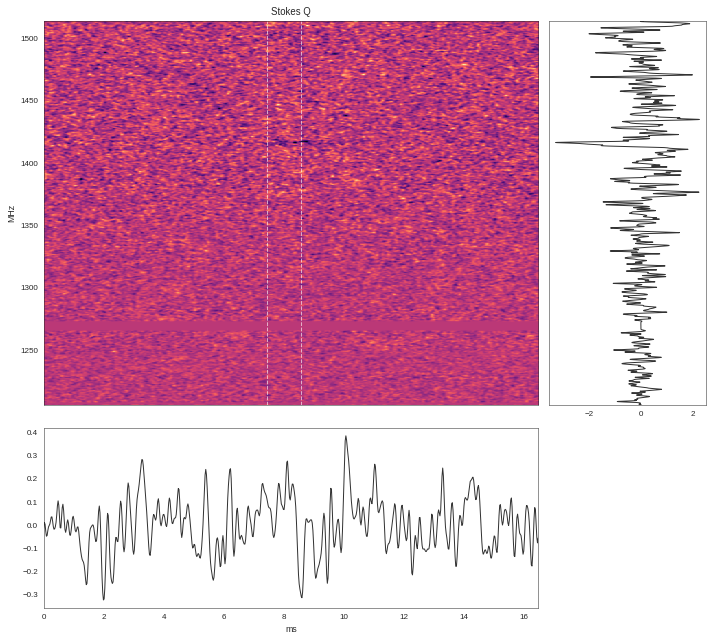

In [20]:
# Stokes Q
polStr = 'Stokes Q'
pIdx = 1

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

#dSpec = plt.imshow(data[0,pIdx], aspect='auto',\
dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

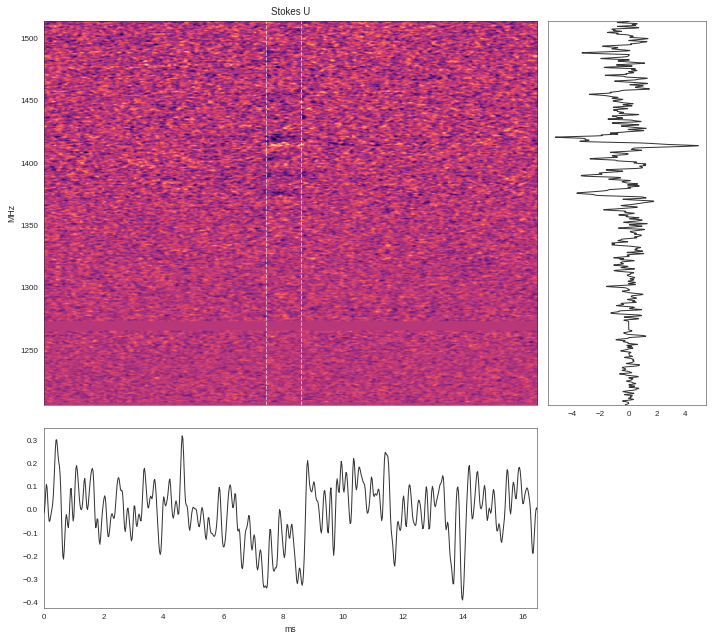

In [21]:
# Stokes U
polStr = 'Stokes U'
pIdx = 2

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

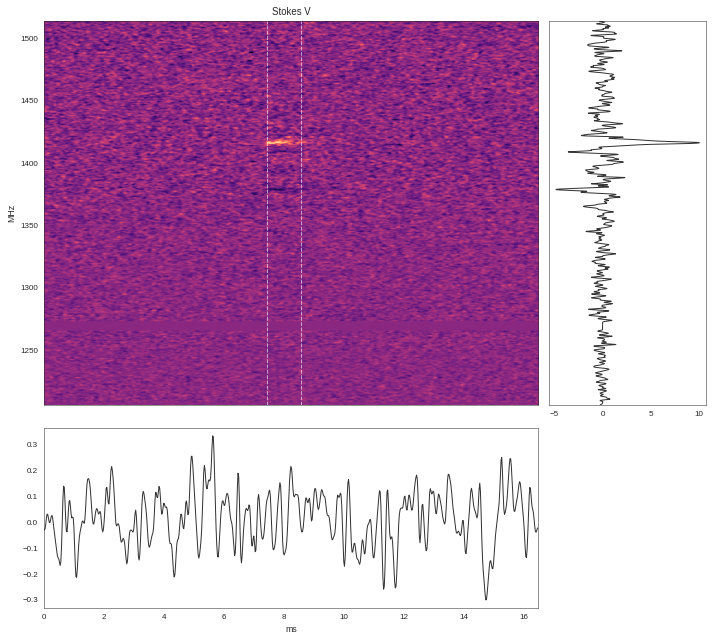

In [22]:
# Stokes V
polStr = 'Stokes V'
pIdx = 3

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(10,9)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])
#plt.scatter(ts[peakIdx[1]], freqsMHz[peakIdx[0]])
plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

plt.title(polStr)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)

plt.plot(ts, timeSeries[0,pIdx], 'k', alpha=0.8)
plt.xlabel('ms')
plt.xlim(ts0, ts1)

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.mean(gaussSubData, axis=3)
#spectrum = np.mean(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,pIdx], np.flipud(freqsMHz), 'k', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])

ax3.get_yaxis().set_visible(False)

plt.tight_layout()

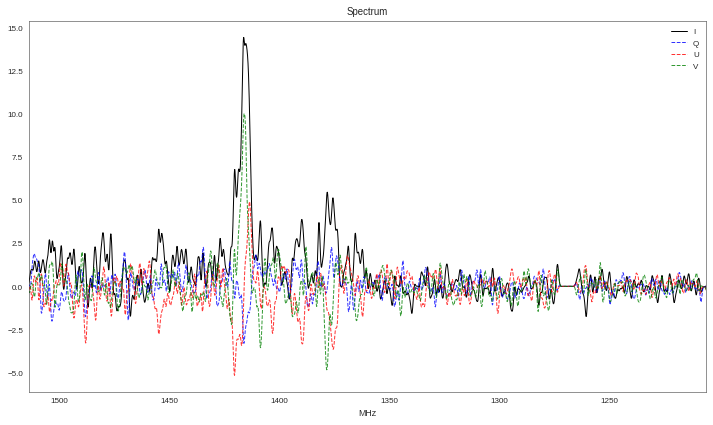

In [23]:
fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(freqsMHz, spectrum[0,0], 'k', label='I', alpha=1.)
plt.plot(freqsMHz, spectrum[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,2], 'r--', label='U', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,3], 'g--', label='V', alpha=0.8)

plt.xlim(freqsMHz[0], freqsMHz[-1])
#plt.xlim(1250., 1240.)
plt.xlabel('MHz')

plt.title('Spectrum')
plt.legend()
plt.tight_layout()

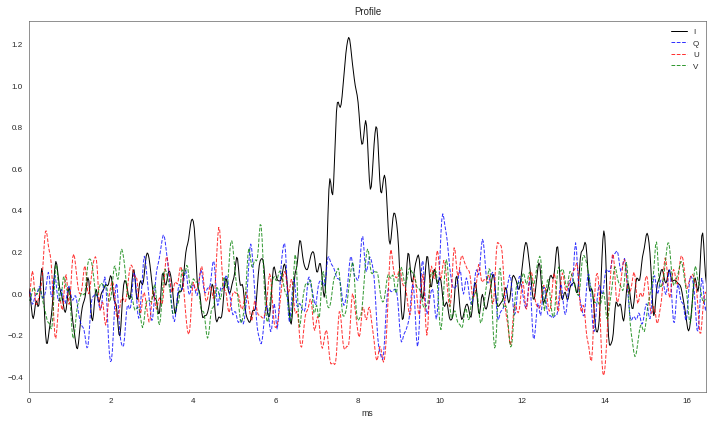

In [24]:
fig = plt.figure(figsize=(10,6)) # (width, height)

plt.plot(ts, timeSeries[0,0], 'k', label='I', alpha=1.)
plt.plot(ts, timeSeries[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(ts, timeSeries[0,2], 'r--', label='U', alpha=0.8)
plt.plot(ts, timeSeries[0,3], 'g--', label='V', alpha=0.8)

plt.xlim(ts0, ts1)
plt.xlabel('ms')

plt.title('Profile')
plt.legend()
plt.tight_layout()

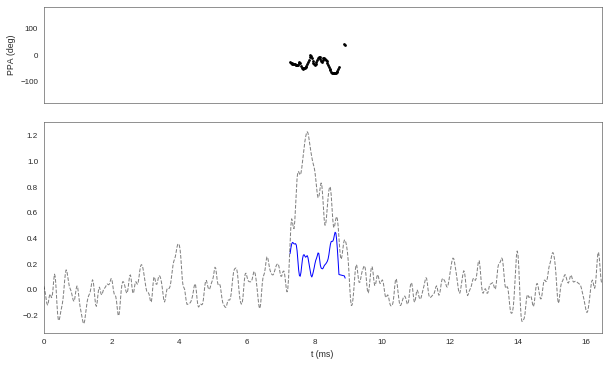

In [25]:
# Position angle and linear polarization fraction
minThresh = 2.25

highSNRidx = np.argwhere(timeSeries[0,0] > minThresh * np.std(timeSeries))

fig = plt.figure(figsize=(10,6)) # (width, height)

LL = np.sqrt((timeSeries[0,1][highSNRidx])**2. + (timeSeries[0,2][highSNRidx])**2.)
linPolFrac = LL / timeSeries[0,0][highSNRidx]
PPA = (0.5 * np.arctan2(timeSeries[0,2][highSNRidx], timeSeries[0,1][highSNRidx])) * (180. / np.pi)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)

plt.plot(ts[highSNRidx], PPA, 'k.')
plt.xlim(ts0, ts1)
plt.ylim(-180., 180.)
ax1.get_xaxis().set_visible(False)
plt.ylabel('PPA (deg)')

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=2)

plt.plot(ts, timeSeries[0,0], 'k--', label='I', alpha=0.5)
plt.plot(ts[highSNRidx], LL, 'b-')

plt.xlim(ts0, ts1)
plt.xlabel('t (ms)')

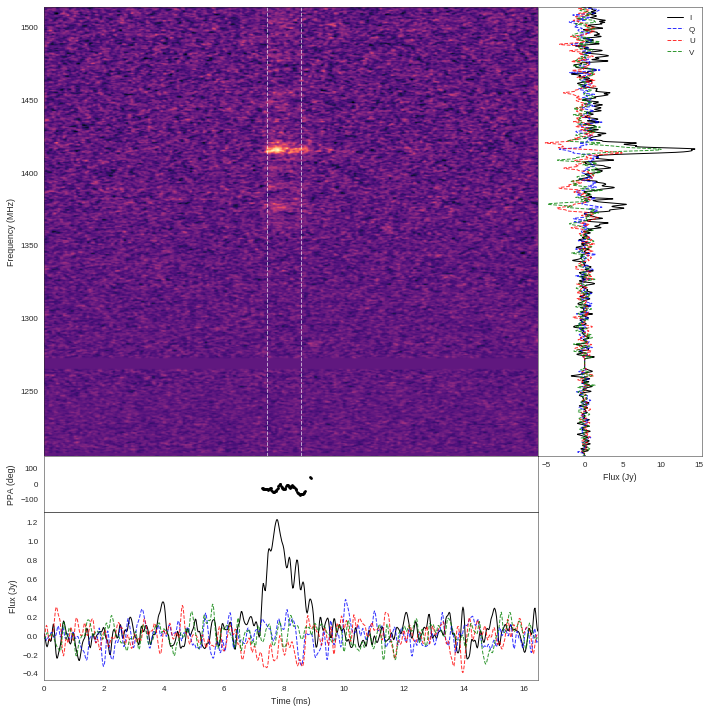

In [26]:
# Manuscript figure
pIdx = 0

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

#fig = plt.figure(figsize=(12,12)) # (width, height)
fig = plt.figure(figsize=(10,10)) # (width, height)

plt.xlabel('ms')
plt.ylabel('MHz')

gs = matplotlib.gridspec.GridSpec(12,4)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:8,0:3])
#ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

dSpec = plt.imshow(gaussSubData[0,pIdx], aspect='auto',\
                   extent=(ts0, ts1, freqsMHz[-1], freqsMHz[0]),\
                   cmap=plt.get_cmap(cmap), interpolation='nearest')
ts = np.linspace(ts0, ts1, gaussSubData.shape[3])

plt.axvline(x=ts[tIdx0], c='w', lw=1, ls='--', alpha=0.6)
plt.axvline(x=ts[tIdx1], c='w', lw=1, ls='--', alpha=0.6)

plt.ylabel('Frequency (MHz)')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[9:12,0:3])
#ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)

timeSeries = np.mean(gaussSubData, axis=2)
plt.plot(ts, timeSeries[0,0], 'k', label='I', alpha=1.)
plt.plot(ts, timeSeries[0,1], 'b--', label='Q', alpha=0.8)
plt.plot(ts, timeSeries[0,2], 'r--', label='U', alpha=0.8)
plt.plot(ts, timeSeries[0,3], 'g--', label='V', alpha=0.8)
plt.xlabel('Time (ms)')
plt.xlim(ts0, ts1)
plt.ylabel('Flux (Jy)')
#plt.legend()

#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot(gs[0:8,3:4])
#ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

#spectrum = np.sum(gaussSubData[:,:,:,peakIdx[1]-tWidth:peakIdx[1]+tWidth], axis=3)
spectrum = np.mean(gaussSubData[:,:,:,tIdx0:tIdx1], axis=3)
plt.plot(spectrum[0,0], np.flipud(freqsMHz), 'k', label='I', alpha=1.)
plt.plot(spectrum[0,1], np.flipud(freqsMHz), 'b--', label='Q', alpha=0.8)
plt.plot(spectrum[0,2], np.flipud(freqsMHz), 'r--', label='U', alpha=0.8)
plt.plot(spectrum[0,3], np.flipud(freqsMHz), 'g--', label='V', alpha=0.8)
plt.ylim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('Flux (Jy)')
plt.legend()

ax3.get_yaxis().set_visible(False)

ax4 = plt.subplot(gs[8:9,0:3])

plt.plot(ts[highSNRidx], PPA, 'k.')
plt.xlim(ts0, ts1)
plt.ylim(-180., 180.)
ax1.get_xaxis().set_visible(False)
plt.ylabel('PPA (deg)')

ax4.get_xaxis().set_visible(False)

plt.subplots_adjust(wspace=0., hspace=0.)

plt.tight_layout()
#plt.savefig('figures/dynamic_spectrum.pdf')
#plt.savefig('180301_dynamic_spectrum_dedisp.png')

### RM Modelling

In [27]:
spectrumRaw = np.mean(scaleSubData[:,:,:,tIdx0:tIdx1], axis=3)

In [28]:
spectrumLtotal = np.sqrt( (spectrum[0,1] * spectrum[0,1]) + (spectrum[0,2] * spectrum[0,2]))

RMval = -3163. # from rmfit
wl = 299792458. / (freqsMHz * 1e6)
rmModel = RMval * wl**2.
print rmModel % 2. * np.pi

[ 6.06607089  6.00973694  5.95339077 ...,  1.73716861  1.62578267
  1.51436642]


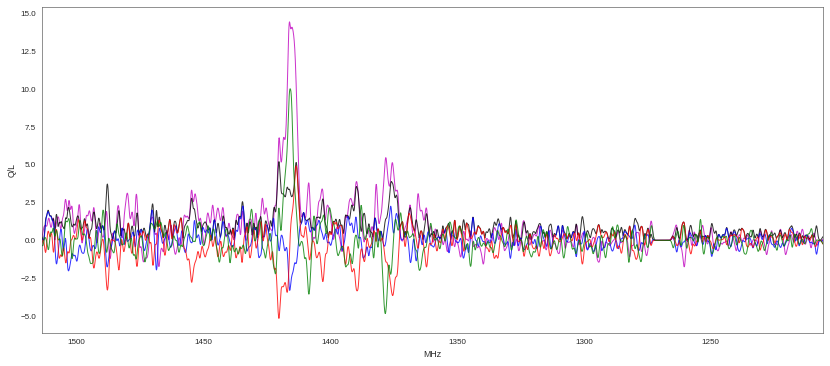

In [29]:
fig = plt.figure(figsize=(14,6)) # (width, height)

plt.plot(freqsMHz, spectrum[0,0], 'm-', label='I', alpha=0.8)
plt.plot(freqsMHz, spectrumLtotal, 'k-', label='L', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,1], 'b-', label='Q', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,2], 'r-', label='U', alpha=0.8)
plt.plot(freqsMHz, spectrum[0,3], 'g-', label='V', alpha=0.8)

plt.xlim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('MHz')
plt.ylabel('Q/L')

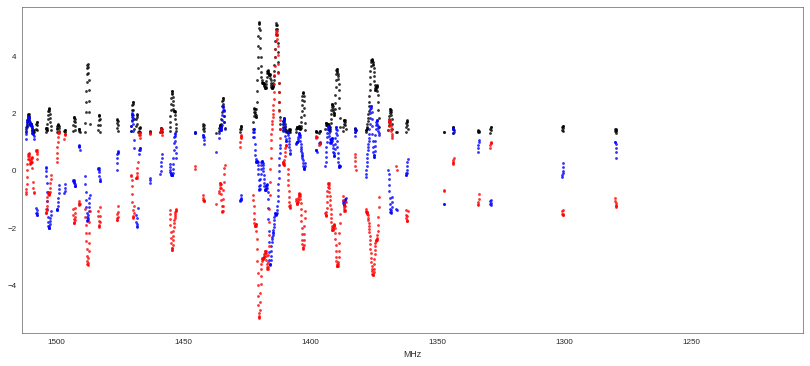

In [30]:
# compute the std on the lower half of the band
linStd = np.std(spectrumLtotal[freqsMHz.shape[0]/2:])
thresh = 4.
threshIdx = np.argwhere(spectrumLtotal > thresh * linStd)

fig = plt.figure(figsize=(14,6)) # (width, height)

plt.plot(freqsMHz[threshIdx], spectrumLtotal[threshIdx], 'k.', label='L', alpha=0.8)
plt.plot(freqsMHz[threshIdx], spectrum[0,1][threshIdx], 'b.', label='Q', alpha=0.8)
plt.plot(freqsMHz[threshIdx], spectrum[0,2][threshIdx], 'r.', label='U', alpha=0.8)

plt.xlim(freqsMHz[0], freqsMHz[-1])
plt.xlabel('MHz')

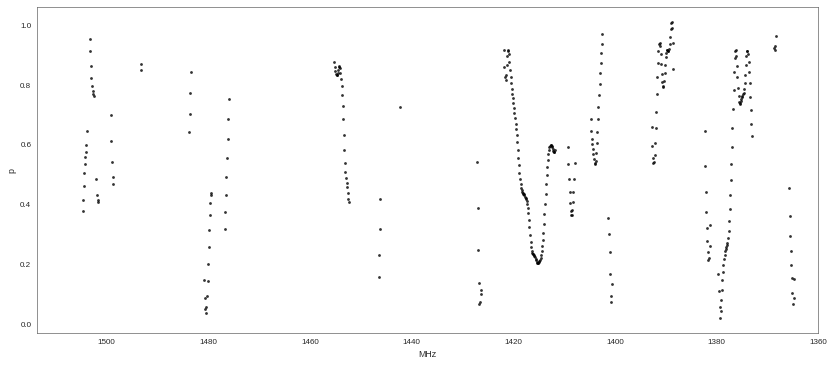

In [31]:
# degree of linear polarization (O'Sullivan et al. 2012, eq 2)
iStd = np.std(spectrum[0,0][freqsMHz.shape[0]/2:])
ithresh = 4.5
ithreshIdx = np.argwhere(spectrum[0,0] > ithresh * iStd)

fig = plt.figure(figsize=(14,6)) # (width, height)

plt.plot(freqsMHz[ithreshIdx], spectrumLtotal[ithreshIdx] / spectrum[0,0][ithreshIdx], 'k.', label='p', alpha=0.8)

plt.xlim(freqsMHz[0], 1360.)
#plt.ylim(-2, 2)
plt.xlabel('MHz')
plt.ylabel('p')

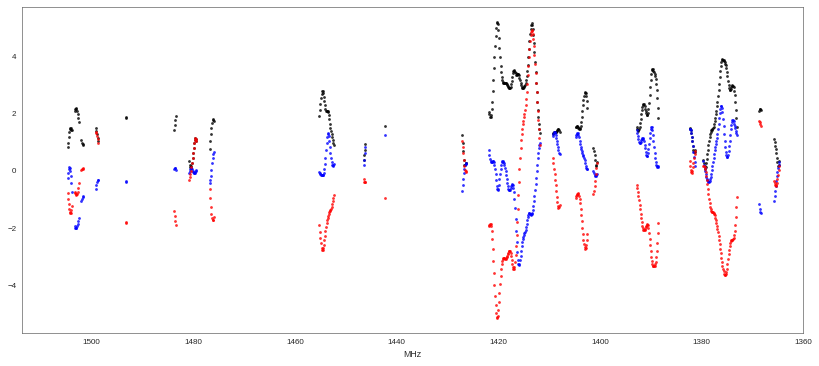

In [32]:
fig = plt.figure(figsize=(14,6)) # (width, height)

plt.plot(freqsMHz[ithreshIdx], spectrumLtotal[ithreshIdx], 'k.', label='L', alpha=0.8)
plt.plot(freqsMHz[ithreshIdx], spectrum[0,1][ithreshIdx], 'b.', label='Q', alpha=0.8)
plt.plot(freqsMHz[ithreshIdx], spectrum[0,2][ithreshIdx], 'r.', label='U', alpha=0.8)

plt.xlim(freqsMHz[0], 1360.)
plt.xlabel('MHz')

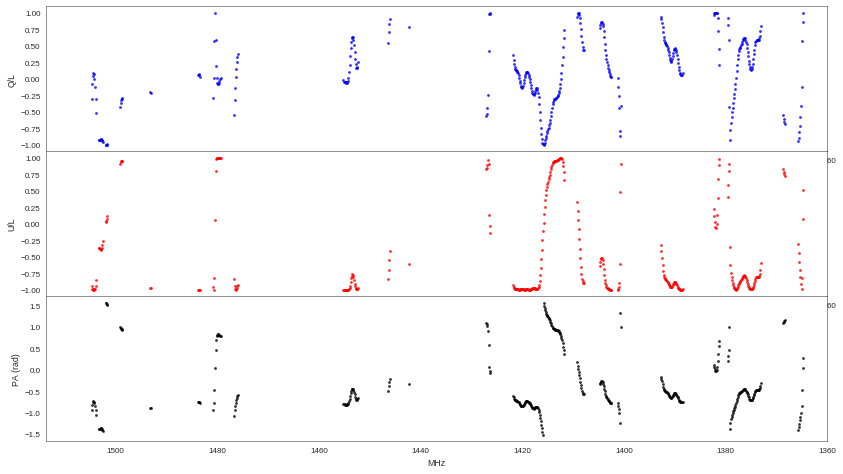

In [33]:
fig = plt.figure(figsize=(14,8)) # (width, height)

gs = matplotlib.gridspec.GridSpec(3,1)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:1,0:1])

plt.plot(freqsMHz[ithreshIdx], spectrum[0,1][ithreshIdx] / spectrumLtotal[ithreshIdx], 'b.', label='Q/L', alpha=0.8)
plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Q/L')

ax2 = plt.subplot(gs[1:2,0:1])

plt.plot(freqsMHz[ithreshIdx], spectrum[0,2][ithreshIdx] / spectrumLtotal[ithreshIdx], 'r.', label='U/L', alpha=0.8)
plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('U/L')

ax3 = plt.subplot(gs[2:3,0:1])

# polarization angle (O'Sullivan et al. 2012, eq 3)
plt.plot(freqsMHz[ithreshIdx], 0.5 * np.arctan2(spectrum[0,2][ithreshIdx], spectrum[0,1][ithreshIdx]), 'k.',\
         label='PA', alpha=0.8)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('PA (rad)')

plt.xlabel('MHz')

In [34]:
import lmfit
import scipy.constants

In [35]:
wlall = scipy.constants.c / (freqsMHz * 1e6) # meters
wlThresh = wlall[ithreshIdx[:,0]]
paObs = 0.5 * np.arctan2(spectrum[0,2][ithreshIdx], spectrum[0,1][ithreshIdx])

In [36]:
def faradayRot(wl, pa0=0., RM=0.):
    """Faraday Rotation model for the polarization angle"""
    return ((pa0 + RM * wl**2.) % np.pi) - (np.pi/2.)

def linearRot(wl, pa0=0., LL=0.):
    """Linear Rotation model for the polarization angle"""
    return ((pa0 + LL * wl) % np.pi) - (np.pi/2.)

Parameters([('pa0', <Parameter 'pa0', 0.63147591026930516, bounds=[0.0:3.141592653589793]>), ('RM', <Parameter 'RM', -3165.8291457286432, bounds=[-10000.0:10000.0]>)])
14.7267818917
Parameters([('pa0', <Parameter 'pa0', 1.3734601048357387, bounds=[0.0:3.141592653589793]>), ('LL', <Parameter 'LL', -1356.7839195979886, bounds=[-10000.0:10000.0]>)])
68.8723265914


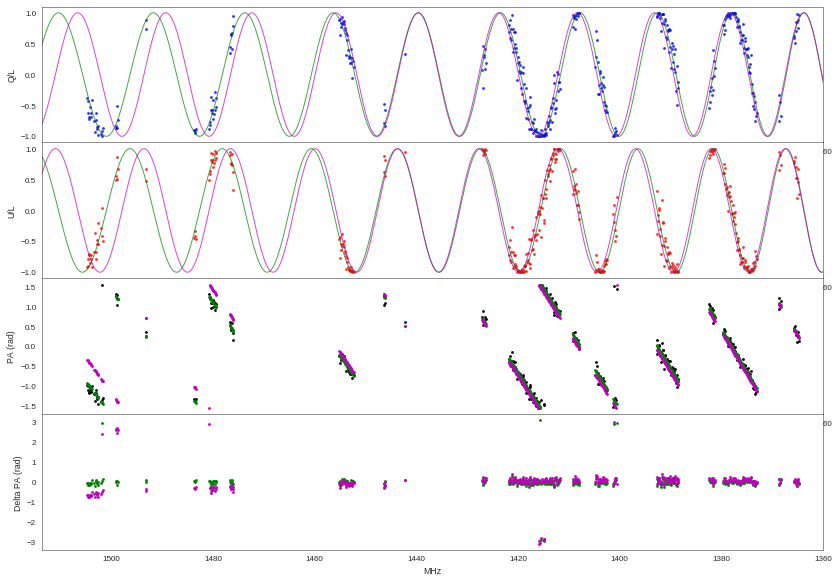

In [37]:
# test data to fit
#paTest = faradayRot(wlThresh, pa0=0.5, RM=-3163.)

# add phase noise
phaseSig = 0.1 # radians
paTest = ((0.5 + (-3163.) * wlThresh**2. + (phaseSig * np.random.randn(wlThresh.shape[0]))) % np.pi) - (np.pi/2.)
#phaseNoise = phaseSig * np.random.randn(paTest.shape[0])
#paTest += phaseNoise

qTest = np.cos(2. * paTest)
uTest = np.sin(2. * paTest)
quTest = np.concatenate((qTest, uTest))

def faradayRes(params, wl, qu):
    pa0 = params['pa0'].value
    RM = params['RM'].value
    
    paModel = (pa0 + RM * wl**2.) - (np.pi/2.)
    qModel = np.cos(2. * paModel)
    uModel = np.sin(2. * paModel)
    quModel = np.concatenate((qModel, uModel))
    
    return qu - quModel

def linearRes(params, wl, qu):
    pa0 = params['pa0'].value
    LL = params['LL'].value
    
    paModel = (pa0 + LL * wl) - (np.pi/2.)
    qModel = np.cos(2. * paModel)
    uModel = np.sin(2. * paModel)
    quModel = np.concatenate((qModel, uModel))
    
    return qu - quModel

faradayParams = lmfit.Parameters()
faradayParams.add('pa0', value=0.0, min=0., max=np.pi)
faradayParams.add('RM', value=0., min=-10000., max=10000.)
faradayOut = lmfit.minimize(faradayRes, faradayParams, args=(wlThresh, quTest), method='brute', Ns=200)

print faradayOut.params
print faradayOut.chisqr

faradayModel = lmfit.models.Model(faradayRot, independent_vars=['wl'])

linearParams = lmfit.Parameters()
linearParams.add('pa0', value=0.0, min=0., max=np.pi)
linearParams.add('LL', value=0., min=-10000., max=10000.)
linearOut = lmfit.minimize(linearRes, linearParams, args=(wlThresh, quTest), method='brute', Ns=200)

print linearOut.params
print linearOut.chisqr

linearModel = lmfit.models.Model(linearRot, independent_vars=['wl'])

# O'Sullivan et al. 2012 eq 1
# Q = pI cos(2 PA)
# U = pI sin(2 PA)

fig = plt.figure(figsize=(14,10)) # (width, height)

gs = matplotlib.gridspec.GridSpec(4,1)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:1,0:1])

plt.plot(freqsMHz[ithreshIdx], qTest, 'b.', label='Q/L', alpha=0.8)
plt.plot(freqsMHz, np.cos(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)
plt.plot(freqsMHz, np.cos(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='Linear', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Q/L')

ax2 = plt.subplot(gs[1:2,0:1])

plt.plot(freqsMHz[ithreshIdx], uTest, 'r.', label='U/L', alpha=0.8)
plt.plot(freqsMHz, np.sin(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)
plt.plot(freqsMHz, np.sin(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='linear', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('U/L')

ax3 = plt.subplot(gs[2:3,0:1])

plt.plot(freqsMHz[ithreshIdx], paTest, 'k.')
plt.plot(freqsMHz[ithreshIdx], faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
                                          RM=faradayOut.params['RM']), 'g.')
plt.plot(freqsMHz[ithreshIdx], linearRot(wlThresh, pa0=linearOut.params['pa0'],\
                                          LL=linearOut.params['LL']), 'm.')

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('PA (rad)')

ax4 = plt.subplot(gs[3:4,0:1])

plt.plot(freqsMHz[ithreshIdx], paTest.flatten() - faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
                                                             RM=faradayOut.params['RM']), 'g.')
plt.plot(freqsMHz[ithreshIdx], paTest.flatten() - linearRot(wlThresh, pa0=linearOut.params['pa0'],\
                                                             LL=linearOut.params['LL']), 'm.')

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Delta PA (rad)')

plt.xlabel('MHz')

Parameters([('pa0', <Parameter 'pa0', 0.088140876052619443, bounds=[0.0:3.141592653589793]>), ('RM', <Parameter 'RM', -3156.3126252505008, bounds=[-5000.0:0.0]>)])
240.672330272
Parameters([('pa0', <Parameter 'pa0', 0.32108461990597081, bounds=[0.0:3.141592653589793]>), ('LL', <Parameter 'LL', -1322.645290581162, bounds=[-5000.0:0.0]>)])
253.766098546


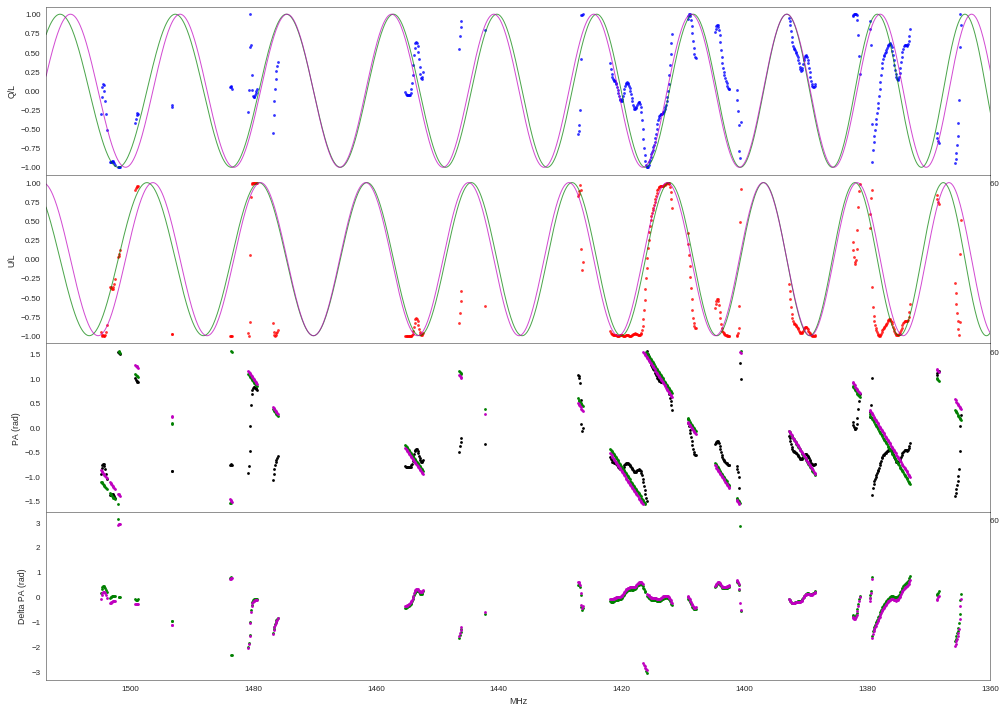

In [44]:
# Faraday fit
QL = spectrum[0,1][ithreshIdx] / spectrumLtotal[ithreshIdx]
UL = spectrum[0,2][ithreshIdx] / spectrumLtotal[ithreshIdx]
quData = np.concatenate((QL.flatten(),UL.flatten()))

faradayParams = lmfit.Parameters()
faradayParams.add('pa0', value=0.0, min=0., max=np.pi)
faradayParams.add('RM', value=-1000., min=-5000., max=0.)
faradayOut = lmfit.minimize(faradayRes, faradayParams, args=(wlThresh, quData), method='brute', Ns=500)

print faradayOut.params
print faradayOut.chisqr

faradayModel = lmfit.models.Model(faradayRot, independent_vars=['wl'])

linearParams = lmfit.Parameters()
linearParams.add('pa0', value=0.0, min=0., max=np.pi)
linearParams.add('LL', value=0., min=-5000., max=0.)
linearOut = lmfit.minimize(linearRes, linearParams, args=(wlThresh, quData), method='brute', Ns=500)

print linearOut.params
print linearOut.chisqr

linearModel = lmfit.models.Model(linearRot, independent_vars=['wl'])

# O'Sullivan et al. 2012 eq 1
# Q = pI cos(2 PA)
# U = pI sin(2 PA)

fig = plt.figure(figsize=(14,10)) # (width, height)

gs = matplotlib.gridspec.GridSpec(4,1)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:1,0:1])

plt.plot(freqsMHz[ithreshIdx], QL.flatten(), 'b.', label='Q/L', alpha=0.8)
plt.plot(freqsMHz, np.cos(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)
plt.plot(freqsMHz, np.cos(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='Linear', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Q/L')

ax2 = plt.subplot(gs[1:2,0:1])

plt.plot(freqsMHz[ithreshIdx], UL.flatten(), 'r.', label='U/L', alpha=0.8)
plt.plot(freqsMHz, np.sin(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)
plt.plot(freqsMHz, np.sin(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='linear', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('U/L')

ax3 = plt.subplot(gs[2:3,0:1])

plt.plot(freqsMHz[ithreshIdx], paObs, 'k.')
plt.plot(freqsMHz[ithreshIdx], faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
                                          RM=faradayOut.params['RM']), 'g.')
plt.plot(freqsMHz[ithreshIdx], linearRot(wlThresh, pa0=linearOut.params['pa0'],\
                                          LL=linearOut.params['LL']), 'm.')

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('PA (rad)')

ax4 = plt.subplot(gs[3:4,0:1])

plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
                                                             RM=faradayOut.params['RM']), 'g.')
plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - linearRot(wlThresh, pa0=linearOut.params['pa0'],\
                                                             LL=linearOut.params['LL']), 'm.')

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Delta PA (rad)')

plt.xlabel('MHz')

plt.tight_layout()
plt.savefig('rmfit_brute.png')

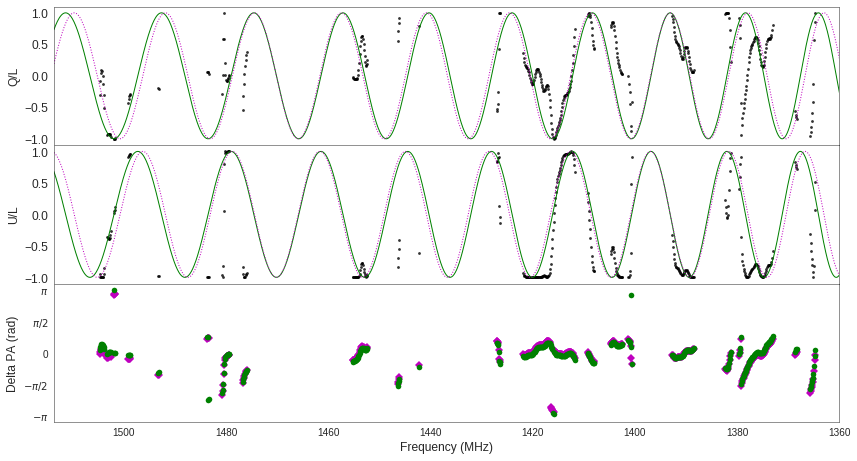

In [72]:
fig = plt.figure(figsize=(12,6.5)) # (width, height)

#gs = matplotlib.gridspec.GridSpec(4,1)
gs = matplotlib.gridspec.GridSpec(3,1)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:1,0:1])

plt.plot(freqsMHz[ithreshIdx], QL.flatten(), 'k.', label='Q/L', alpha=0.8)
plt.plot(freqsMHz, np.cos(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=1)
plt.plot(freqsMHz, np.cos(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm:', label='Linear', alpha=1)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Q/L', fontsize=12)

ax1.tick_params(labelsize=12)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot(gs[1:2,0:1])

plt.plot(freqsMHz[ithreshIdx], UL.flatten(), 'k.', label='U/L', alpha=0.8)
plt.plot(freqsMHz, np.sin(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=1)
plt.plot(freqsMHz, np.sin(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm:', label='linear', alpha=1)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('U/L', fontsize=12)

ax2.tick_params(labelsize=12)

ax2.get_xaxis().set_visible(False)

#ax3 = plt.subplot(gs[2:3,0:1])

#plt.plot(freqsMHz[ithreshIdx], paObs, 'k.')
#plt.plot(freqsMHz[ithreshIdx], faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
#                                          RM=faradayOut.params['RM']), 'g.')
#plt.plot(freqsMHz[ithreshIdx], linearRot(wlThresh, pa0=linearOut.params['pa0'],\
#                                          LL=linearOut.params['LL']), 'm.')

#plt.xlim(freqsMHz[0], 1360.)
#plt.ylabel('PA (rad)')

#ax4 = plt.subplot(gs[3:4,0:1])
ax4 = plt.subplot(gs[2:3,0:1])

plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - linearRot(wlThresh, pa0=linearOut.params['pa0'],\
                                                             LL=linearOut.params['LL']), 'mD', alpha=1)
plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - faradayRot(wlThresh, pa0=faradayOut.params['pa0'],\
                                                             RM=faradayOut.params['RM']), 'go', alpha=1)

#plt.yticks(np.arange(-1.*np.pi, np.pi, step=np.pi/4))
#plt.yticks(np.linspace(-1.*np.pi, np.pi, 5))
plt.yticks(np.linspace(-1.*np.pi, np.pi, 5), ('$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'))
plt.ylim(-1.1*np.pi, 1.1*np.pi)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Delta PA (rad)', fontsize=12)
plt.xlabel('Frequency (MHz)', fontsize=12)

ax4.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('QUfit_brute.pdf')

---

In [40]:
faradayModel = lmfit.models.Model(faradayRot, independent_vars=['wl'])
print faradayModel.param_names, faradayModel.independent_vars

#faradayModel.set_param_hint('pa0', min=-1.*np.pi/2., max=np.pi/2.)
faradayModel.set_param_hint('pa0', min=0., max=np.pi, value=0.)
faradayModel.set_param_hint('RM', min=-10000., max=10000., value=-3163.)
#faradayModel.set_param_hint('RM', min=-10000., max=10000.)
faradayParams = faradayModel.make_params()
print faradayParams
faradayOut = faradayModel.fit(paObs, faradayParams, wl=wlThresh, weights=spectrum[0,0][ithreshIdx])
#faradayOut = faradayModel.fit(paObs, faradayParams, wl=wlThresh, weights=spectrum[0,0][ithreshIdx], method='brute',\
#                             fit_kws={'Ns':100})
print faradayOut.fit_report()

linearModel = lmfit.models.Model(linearRot, independent_vars=['wl'])
print linearModel.param_names, linearModel.independent_vars

#linearModel.set_param_hint('pa0', min=-1.*np.pi/2., max=np.pi/2., value=0.)
#linearModel.set_param_hint('pa0', min=0., max=np.pi, value=0.)
linearModel.set_param_hint('pa0', min=0., max=np.pi, value=0., brute_step=np.pi/100.)
#linearModel.set_param_hint('LL', min=-10000., max=10000., value=0.)
#linearModel.set_param_hint('LL', min=-10000., max=10000., value=-1000.)
linearModel.set_param_hint('LL', min=-2000., max=-1000., value=-1500., brute_step=100.)
linearParams = linearModel.make_params()
print linearParams
#linearOut = linearModel.fit(paObs, linearParams, wl=wlThresh, weights=spectrum[0,0][ithreshIdx])
linearOut = linearModel.fit(paObs, linearParams, wl=wlThresh, weights=spectrum[0,0][ithreshIdx], method='brute',\
                            fit_kws={'Ns':100})
print linearOut.fit_report()

['pa0', 'RM'] ['wl']
Parameters([('pa0', <Parameter 'pa0', 0.0, bounds=[0.0:3.141592653589793]>), ('RM', <Parameter 'RM', -3163.0, bounds=[-10000.0:10000.0]>)])
[[Model]]
    Model(faradayRot)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 126025
    # variables        = 2
    chi-square         = 6522880.833
    reduced chi-square = 51.759
    Akaike info crit   = 497373.144
    Bayesian info crit = 497392.632
[[Variables]]
    pa0:   0          +/- 0        (nan%) (init= 0)
    RM:   -3143.29107 +/- 0        (0.00%) (init=-3163)

['pa0', 'LL'] ['wl']


/home/griffin/.local/lib/python2.7/site-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))
/home/griffin/.local/lib/python2.7/site-packages/lmfit/model.py:324: UserWarning: unknown parameter hint 'brute_step' for param 'pa0'
  warnings.warn(self._invalid_hint % (key, name))
/home/griffin/.local/lib/python2.7/site-packages/lmfit/model.py:324: UserWarning: unknown parameter hint 'brute_step' for param 'LL'
  warnings.warn(self._invalid_hint % (key, name))


Parameters([('pa0', <Parameter 'pa0', 0.0, bounds=[0.0:3.141592653589793]>), ('LL', <Parameter 'LL', -1500.0, bounds=[-2000.0:-1000.0]>)])
[[Model]]
    Model(linearRot)
[[Fit Statistics]]
    # function evals   = 10002
    # data points      = 126025
    # variables        = 2
    chi-square         = 5847663.447
    reduced chi-square = 46.402
    Akaike info crit   = 483601.894
    Bayesian info crit = 483621.382
[[Variables]]
    pa0:   0.19039955 (init= ?)
    LL:   -1595.95959 (init= ?)



In [41]:
print faradayOut.best_values
print linearOut.best_values

print linearModel.eval(linearOut.params, wl=wlall)

{'pa0': 0.0, 'RM': -3143.2910769236432}
{'pa0': 0.19039955476301779, 'LL': -1595.9595959595958}
[-0.16471534 -0.18755634 -0.21040064 ...,  0.87935617  0.8433739
  0.80738511]


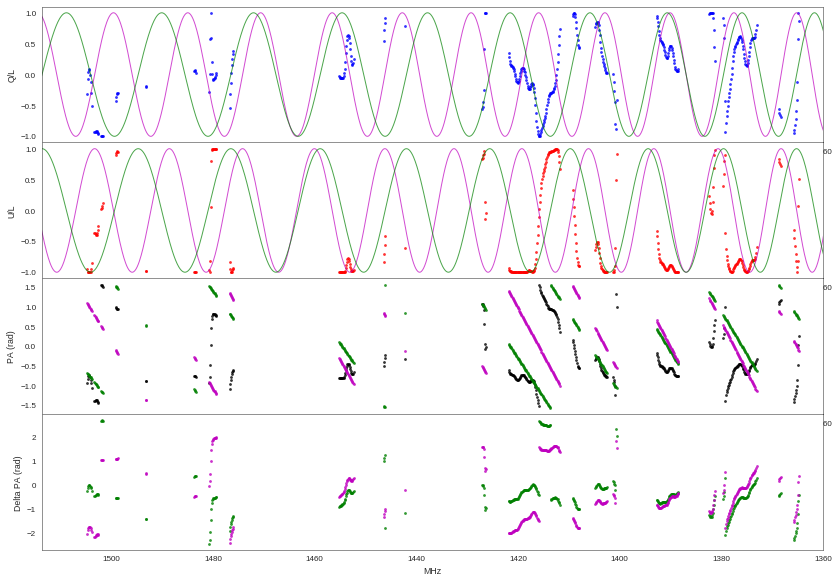

In [42]:
# O'Sullivan et al. 2012 eq 1
# Q = pI cos(2 PA)
# U = pI sin(2 PA)

fig = plt.figure(figsize=(14,10)) # (width, height)

gs = matplotlib.gridspec.GridSpec(4,1)
gs.update(hspace=0.0, wspace=0.0)
ax1 = plt.subplot(gs[0:1,0:1])

plt.plot(freqsMHz[ithreshIdx], spectrum[0,1][ithreshIdx] / spectrumLtotal[ithreshIdx], 'b.', label='Q/L', alpha=0.8)

plt.plot(freqsMHz, np.cos(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='linear', alpha=0.7)
plt.plot(freqsMHz, np.cos(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Q/L')

ax2 = plt.subplot(gs[1:2,0:1])

plt.plot(freqsMHz[ithreshIdx], spectrum[0,2][ithreshIdx] / spectrumLtotal[ithreshIdx], 'r.', label='U/L', alpha=0.8)

plt.plot(freqsMHz, np.sin(2. * linearModel.eval(linearOut.params, wl=wlall)), 'm-', label='linear', alpha=0.7)
plt.plot(freqsMHz, np.sin(2. * faradayModel.eval(faradayOut.params, wl=wlall)), 'g-', label='Faraday', alpha=0.7)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('U/L')

ax3 = plt.subplot(gs[2:3,0:1])

# polarization angle (O'Sullivan et al. 2012, eq 3)
plt.plot(freqsMHz[ithreshIdx], 0.5 * np.arctan2(spectrum[0,2][ithreshIdx], spectrum[0,1][ithreshIdx]), 'k.',\
         label='PA', alpha=0.8)

plt.plot(freqsMHz[ithreshIdx], faradayOut.best_fit, 'g.', alpha=0.8)
plt.plot(freqsMHz[ithreshIdx], linearOut.best_fit, 'm.', alpha=0.8)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('PA (rad)')

ax4 = plt.subplot(gs[3:4,0:1])

plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - faradayOut.best_fit, 'g.', alpha=0.8)
plt.plot(freqsMHz[ithreshIdx], paObs.flatten() - linearOut.best_fit, 'm.', alpha=0.8)

plt.xlim(freqsMHz[0], 1360.)
plt.ylabel('Delta PA (rad)')

plt.xlabel('MHz')